## Tutorial 2 - Using shape to mask a raster

In this tutorial we will know how to use a geometry object from a shapefile to stencil a part of the raster within the geometry. To achieve this, we use `rasterio.mask.mask` function call. Masking this way is very efficient because the masking is done at data reading level, not after the whole image is read onto the memory.

In [1]:
import os
# pandas package specialized for geospatial analysis
import geopandas as gpd
from matplotlib import pyplot as plt
# draw everything within the notebook
%matplotlib inline

In [2]:
# shapefile path
cambodia_waterbodies_path = '/home/dp/Documents/Projects/HydroViet/water-bodies-09-08-2016'
df = gpd.read_file(cambodia_waterbodies_path)

Now we are interested in only the Tonle Sap lake, which is

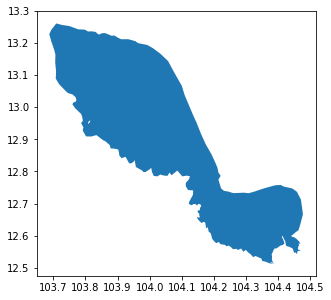

In [3]:
plt.rcParams['figure.figsize'] = 5, 5
tonlesap = df[df.name == 'Boeung Tonle Sap']
tonlesap.plot();

To overlay the Tonle Sap lake onto a raster, we go to Libra brower and take down three bands Red, NIR, and SWIR of the area.

In [4]:
# raster tile of Landsat-8
# You must download your own tiles and change the paths accordingly

tile_landsat_paths = ['/home/dp/Documents/Projects/HydroViet/tonlesap/LC08_L1TP_127051_20171213_20171223_01_T1_B4.TIF',
                        '/home/dp/Documents/Projects/HydroViet/tonlesap/LC08_L1TP_127051_20171213_20171223_01_T1_B5.TIF',
                        '/home/dp/Documents/Projects/HydroViet/tonlesap/LC08_L1TP_127051_20171213_20171223_01_T1_B6.TIF']

In [5]:
import numpy as np
import rasterio as rio
from rasterio.crs import CRS
from rasterio.warp import transform_geom
from shapely.geometry import shape, mapping, Polygon, MultiPolygon
from matplotlib.collections import PatchCollection
from descartes import PolygonPatch

`RasterIO` is a versatile Python package, built on top of GDAL, allow flexible raster and vector manipulations. By default it reads in GEOTIFF image formats. `rasterio.mask` is the package allowing masking a part of the raster, so we import it in the below.

In [6]:
import rasterio.mask

In [8]:
# We obtain the shape object of Tonle Sap from the Pandas table as follows
tonlesap_shape = tonlesap.geometry.values[0]

# Notice the object signature of the shape by uncommenting this print
## print(tonlesap_shape)

# `rasterio.mask.mask` requires inputs as a list of geometry objects, not shape objects. In order
# obtain the geometry ojbect, strip off  the shape wapper, so you will get the "kernel" as 
# a geometry object
tonlesap_geom = mapping(tonlesap_shape)

It's time to read in the masked rasters using the following code snippet. Remember by masking a part of the raster, the original transformation matrix of the raster should not be used because it is invalid for the returned (sub)-raster. Think about the mask lies somewhere in the middle of the raster, so that at least the translation entries of the transformation matrix has to be updated. Fortunately, `rasterio.mask.mask` does for us, and also returns the updated transformation matrix, besides the masked raster. Save  this for later processing.

In [10]:
with rio.open(tile_landsat_paths[0]) as src:
    # Now, as the previous tutorial, we transform the geometry ojbect to the CRS of the 
    # Landsat images at the same time we open it for reading
    tonlesap_shape = [transform_geom(df.crs, src.crs, tonlesap_geom)]
    red, trans = rasterio.mask.mask(src, tonlesap_shape, crop=True)
    crs = src.crs
    trans = src.transform
    bounds = src.bounds
    meta = src.meta.copy()
    
with rio.open(tile_landsat_paths[1]) as src:
    nir, _ = rasterio.mask.mask(src, tonlesap_shape, crop=True)
    
with rio.open(tile_landsat_paths[2]) as src:
    swir, _ = rasterio.mask.mask(src, tonlesap_shape, crop=True)

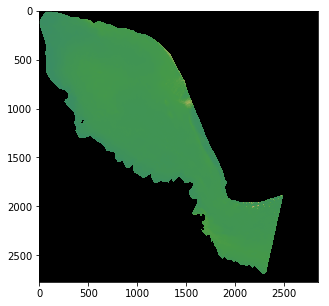

In [12]:
# Show the masked object, now just the Tonle Sap lake is shown, not surrounding vegetations.
# You can select different colormaps to characterize better the image content. In the below, 
# plt.cm.gist_earth is selected. Try more at https://matplotlib.org/users/colormaps.html

plt.imshow(red.squeeze(), cmap=plt.cm.gist_earth);

Want to get rid off the black area? Let's make the raster as a masked numpy raster which is available under the package `numpy.ma`. So here we wrap the `red` channel with a `np.ma.array`. Any processing on the new array will involve the `mask`. We can define the color for masked display using `set_bad()` method. See the difference.

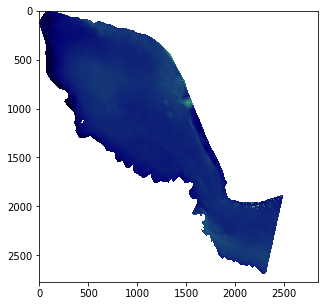

In [14]:
masked_red = red.squeeze()
masked_red = np.ma.array(masked_red, mask=(masked_red==0), fill_value=0)
cmap = plt.cm.gist_earth
cmap.set_bad('white')
plt.imshow(masked_red, cmap=cmap);